In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D, concatenate, Flatten, Reshape
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras import Input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
## 하이퍼 파라메터

delta = 1e-7
seq_len = 30
test_date = 365
factor_num = 4

level_1 = 50
level_2 = 100
level_3 = 150

num_level = 4

pm_target = level_3 * 2
temp_target = 24 * 2
humidity_target = 100
wind_speed_target = 14 # 강한 바람
wind_direction_target = 360*2 # 16방위

year = 365
train_cut = year * 6 + 2

test_cut = -test_date

In [5]:
## 데이터 로드
data = pd.read_csv('/content/drive/MyDrive/busan/project/dataset/raw_dataset(W_direction).csv', index_col=0)
data.head()

,Temperature,W_speed,W_direction,Humidity,Tianjin,Weihai,Seoul
Date,,,,,,,
2014-01-01,4.0,3.7,12,51.3,136,116,125
2014-01-02,1.5,2.0,13,35.4,216,80,56
2014-01-03,2.3,2.5,2,54.4,102,67,59
2014-01-04,-0.1,2.4,12,47.1,74,30,51
2014-01-05,-0.8,1.9,12,48.4,114,77,45


In [6]:
## 초기 데이터 입력

pm_seoul_data = data['Seoul'].values
pm_tianjin_data = data['Tianjin'].values
pm_weihai_data = data['Weihai'].values
temp_data = data['Temperature'].values
humidity_data = data['Humidity'].values
wind_direction_data = data['W_direction'].values
wind_speed_data = data['W_speed'].values

In [7]:
## 시계열 함수
def make_sequential(data):
    for i in range(len(data)):
        if data[i] == 0:
            data[i] = data[i]+delta
        
    sequence_length = seq_len + 1
    
    temp_data = []
    for index in range((len(data) - sequence_length)+1):
        temp_data.append(data[index: index + sequence_length])
        
    return np.array(temp_data)

In [8]:
def pm_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / pm_target)
        
    return norm_data

In [9]:
def temp_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append((data[i] / temp_target)**2)
        
    return norm_data

In [10]:
def humidity_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append((data[i] / humidity_target)**2)
        
    return norm_data

In [11]:
def wind_speed_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / wind_speed_target)
        
    return norm_data

In [12]:
def wind_direction_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append((data[i] / wind_direction_target)**2)
        
    return norm_data

In [13]:
norm_pm_seoul = make_sequential(pm_norm_window(pm_seoul_data)) #a
norm_pm_tianjin = make_sequential(pm_norm_window(pm_tianjin_data)) #b
norm_pm_weihai = make_sequential(pm_norm_window(pm_weihai_data)) #c
norm_temp = make_sequential(temp_norm_window(temp_data)) #d
norm_humidity = make_sequential(humidity_norm_window(humidity_data)) #e
norm_wind_speed = make_sequential(wind_speed_norm_window(wind_speed_data)) #f
norm_wind_direction = make_sequential(wind_direction_norm_window(wind_direction_data)) #g

In [14]:
## 병합함수

def marge_data(a, b, c, d, e, f, g):
    marged_data = []
    marge = []
    
    for a_index, b_index, c_index, d_index, e_index, f_index, g_index in zip(a, b, c, d, e, f, g):
        for i in range(len(a_index)):
            marge.append(a_index[i])
            # marge.append(b_index[i])
            marge.append(c_index[i])
            marge.append(d_index[i])
            marge.append(e_index[i])
            # marge.append(f_index[i])
            # marge.append(g_index[i])
            # marge.append(h_index[i])
            
        for i in range(factor_num-1):
            marge.pop()
        
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_pm_seoul, norm_pm_tianjin, norm_pm_weihai, norm_temp, norm_humidity, norm_wind_speed, norm_wind_direction)

In [15]:
train = norm_result[:train_cut, :]
np.random.shuffle(train)

valid = norm_result[train_cut:test_cut, :]
#np.random.shuffle(valid)

test = norm_result[test_cut:, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]
y_train = np.reshape(y_train, (y_train.shape[0], 1))

x_valid = valid[:, :-1]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = valid[:,-1]
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

x_test = test[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:,-1]
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(2192, 120, 1) (227, 120, 1) (365, 120, 1)
(2192, 1) (227, 1) (365, 1)


In [16]:
### LCRNN 모델 설계
model = Sequential()

model.add(Conv1D(32, 2, activation='linear',strides=2, input_shape=(seq_len*factor_num,1)))
model.add(Conv1D(64, 3, activation='linear',strides=2))
model.add(Conv1D(128, 1, activation='linear',strides=1))

# model.add(Conv1D(60, 3, activation='relu',strides=1, padding="same"))
for i in range (2):
    model.add(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))


model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 32)            96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 29, 128)           8320      
_________________________________________________________________
lstm (LSTM)                  (None, 29, 128)           131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 29, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [17]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.compile(loss='mse', optimizer='adam')

hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs = 30, batch_size = 100)
#hist = model.fit(x_train_dict, y_train, validation_data=(x_valid_dict, y_valid), epochs=20, batch_size=100)

Epoch 1/30
22/22 [==============================] - 17s 415ms/step - loss: 0.0085 - val_loss: 0.0021
Epoch 2/30
22/22 [==============================] - 8s 373ms/step - loss: 0.0061 - val_loss: 0.0023
Epoch 3/30
22/22 [==============================] - 8s 361ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 4/30
22/22 [==============================] - 8s 363ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 5/30
22/22 [==============================] - 8s 367ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 6/30
22/22 [==============================] - 8s 367ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 7/30
22/22 [==============================] - 8s 374ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 8/30
22/22 [==============================] - 8s 364ms/step - loss: 0.0058 - val_loss: 0.0021
Epoch 9/30
22/22 [==============================] - 8s 371ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 10/30
22/22 [==============================] - 8s 369ms/step - loss: 0.0056 - val_loss: 0.002

In [18]:
# model.save('/content/drive/MyDrive/busan/project/Model/LCNN_four(tem,hum,WH).h5')

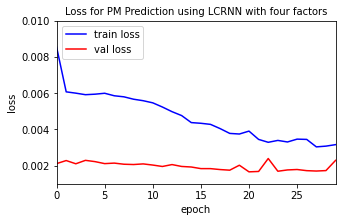

In [26]:
## 손실함수 변화 측정
fig = plt.figure(facecolor='white', figsize=(5, 3))
loss_ax = fig.add_subplot(111)

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.1, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.title('Loss for PM Prediction using LCRNN with four factors', fontsize=10)

plt.xlim([0, 29])
plt.ylim([0.001, 0.01])

plt.show()

In [27]:
## 결과 실제화
y_true = pm_seoul_data[test_cut:]

pred = model.predict(x_test)

y_pred = pred * pm_target

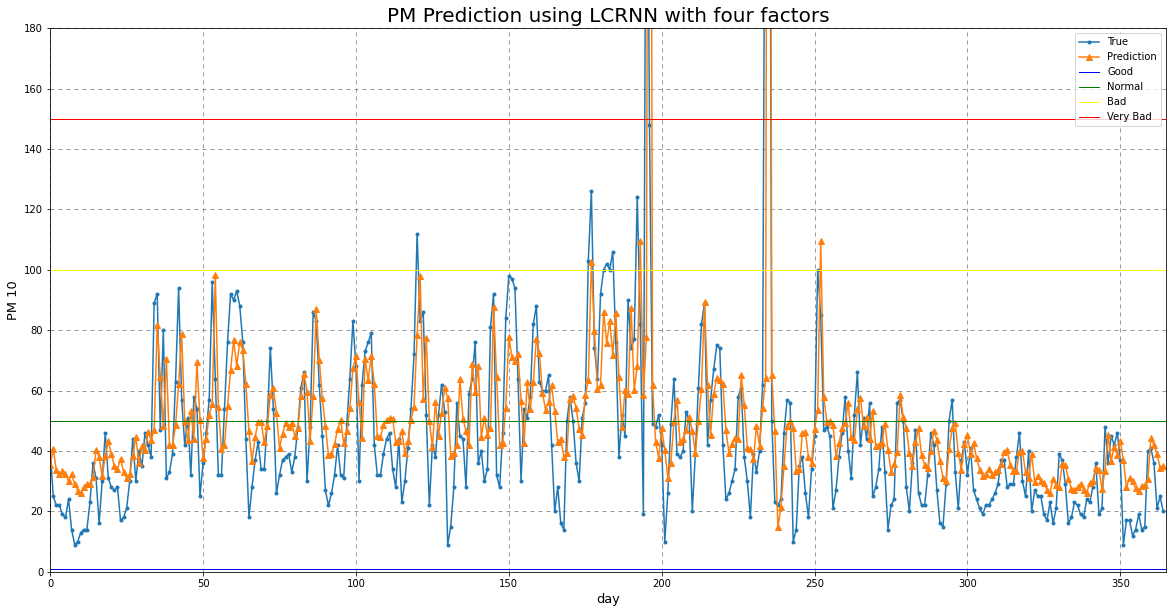

In [28]:
fig = plt.figure(facecolor='white', figsize=(20, 10))

plt.title('PM Prediction using LCRNN with four factors', fontsize=20)

ax = fig.add_subplot(111)
ax.plot(y_true, label='True', marker='.')
ax.plot(y_pred, label='Prediction', marker='^')

plt.grid(color='gray', dashes=(5,5))

plt.axhline(y=1, color='blue', linewidth=1, label='Good')
plt.axhline(y=level_1, color='green', linewidth=1, label='Normal')
plt.axhline(y=level_2, color='yellow', linewidth=1, label='Bad')
plt.axhline(y=level_3, color='red', linewidth=1, label='Very Bad')

plt.xlabel('day', fontsize=13)
plt.ylabel('PM 10', fontsize=13)

plt.xlim([0, test_date])
plt.ylim([0, 180])

ax.legend()
plt.show()

In [29]:
## 단계별 정확도 및 총 정확도 계산 함수
def pm_level(pm):
    
    level_temp = []
    
    for i in range(len(pm)):
        if pm[i] <= level_1:
            level_temp.append(1)
        elif pm[i] <= level_2:
            level_temp.append(2)
        elif pm[i] <= level_3:
            level_temp.append(3)
        else:
            level_temp.append(4)
            
    return level_temp
    

In [30]:
def error_check(true, pred):
    y_true_lv = pm_level(true)
    y_pred_lv = pm_level(pred)
    
    level_1_acc = 0
    level_2_acc = 0
    level_3_acc = 0
    level_4_acc = 0

    level_1_count = y_true_lv.count(1)
    level_2_count = y_true_lv.count(2)
    level_3_count = y_true_lv.count(3)
    level_4_count = y_true_lv.count(4)
            
    
    error_rate_temp = []
    
    for i in range(len(y_pred_lv)):
        if y_pred_lv[i] == y_true_lv[i]:
            error_rate_temp.append(1)
            
            if y_pred_lv[i] == 1:
                level_1_acc += 1
            elif y_pred_lv[i] == 2:
                level_2_acc += 1
            elif y_pred_lv[i] == 3:
                level_3_acc += 1
            else:
                level_4_acc += 1
                    
        else:
            error_rate_temp.append(0)
    
    total_acc = sum(error_rate_temp) / len(error_rate_temp)
    
    
    level_1_accuracy = float(level_1_acc / level_1_count)
    level_2_accuracy = float(level_2_acc / level_2_count)
    level_3_accuracy = float(level_3_acc / level_3_count)
    level_4_accuracy = float(level_4_acc / level_4_count)
    
    level_accuracy = [level_1_accuracy,level_2_accuracy, level_3_accuracy, level_4_accuracy]
    
    return total_acc, level_accuracy


In [31]:
## 정확도 결과
total_acc, level_acc = error_check(y_true, y_pred)
print("total accuracy:", total_acc)
print("level 'Good' accuracy:", level_acc[0])
print("level 'Normal' accuracy:", level_acc[1])
print("level 'Bad' accuracy:", level_acc[2])
print("level 'Very Bad' accuracy:", level_acc[3])

total accuracy: 0.7780821917808219
level 'Good' accuracy: 0.8313725490196079
level 'Normal' accuracy: 0.7
level 'Bad' accuracy: 0.14285714285714285
level 'Very Bad' accuracy: 0.3333333333333333


In [37]:
date = [20210923, 20210924, 20210925, 20210926, 20210927, 20210928, 2021929, 20210930, 
        20211001, 20211002, 20211003, 20211004, 20211005, 20211006, 20211007, 20211008, 20211009, 20211010,
        20211011, 20211012, 20211013, 20211014, 20211015, 20211016, 20211017, 20211018, 20211019, 20211020,
        20211021, 20211022, 20211023, 20211024, 20211025, 20211026, 20211027, 20211028, 20211029, 20211030, 20211031,
        20211101, 20211102, 20211103, 20211104, 20211105, 20211106, 20211107, 20211108, 20211109, 20211110,
        20211111, 20211112, 20211113, 20211114, 20211115, 20211116, 20211117, 20211118, 20211119, 20211120,
        20211121, 20211122, 20211123, 20211124, 20211125, 20211126, 20211127, 20211128, 20211129, 20211130,
        20211201, 20211202, 20211203, 20211204, 20211205, 20211206, 20211207, 20211208, 20211209, 20211210,
        20211211, 20211212, 20211213, 20211214, 20211215, 20211216, 20211217, 20211218, 20211219, 20211220,
        20211221, 20211222, 20211223, 20211224, 20211225, 20211226, 20211227, 20211228, 20211229, 20211230, 20211231]

In [38]:
def date_indexing(date) :
    if date == '20210923' :
        return y_pred[265]
    elif date == '20210924' :
        return y_pred[266]
    elif date == '20210925' :
        return data[267]
    elif date == '20210926' :
        return data[268]
    elif date == '20210927' :
        return data[269]
    elif date == '20210928' :
        return data[270]
    elif date == '20210929' :
        return data[271]
    elif date == '20210930' :
        return data[272]
    elif date == '20211001' :
        return data[273]
    elif date == '20211002' :
        return data[274]
    elif date == '20211003' :
        return data[275]
    elif date == '20211004' :
        return data[276]
    elif date == '20211005' :
        return data[277]
    elif date == '20211006' :
        return data[278]
    elif date == '20211007' :
        return data[279]
    elif date == '20211008' :
        return data[280]
    elif date == '20211009' :
        return data[281]
    elif date == '20211010' :
        return data[282]
    elif date == '20211011' :
        return data[283]
    elif date == '20211012' :
        return data[284]
    elif date == '20211013' :
        return data[285]
    elif date == '20211014' :
        return data[286]
    elif date == '20211015' :
        return data[287]
    elif date == '20211016' :
        return data[288]
    elif date == '20211017' :
        return data[289]
    elif date == '20211018' :
        return data[290]
    elif date == '20211019' :
        return data[291]
    elif date == '20211020' :
        return data[292]
    elif date == '20211021' :
        return data[293]
    elif date == '20211022' :
        return data[294]
    elif date == '20211023' :
        return data[295]
    elif date == '20211024' :
        return data[296]
    elif date == '20211025' :
        return data[297]
    elif date == '20211026' :
        return data[298]
    elif date == '20211027' :
        return data[299]
    elif date == '20211028' :
        return data[300]
    elif date == '20211029' :
        return data[301]
    elif date == '20211030' :
        return data[302]
    elif date == '20211031' :
        return data[303]
    elif date == '20211101' :
        return data[304]
    elif date == '20211102' :
        return data[305]
    elif date == '20211103' :
        return data[306]
    elif date == '20211104' :
        return data[307]
    elif date == '20211105' :
        return data[308]
    elif date == '20211106' :
        return data[309]
    elif date == '20211107' :
        return data[310]
    elif date == '20211108' :
        return data[311]
    elif date == '20211109' :
        return data[312]
    elif date == '20211110' :
        return data[313]
    elif date == '20211111' :
        return data[314]
    elif date == '20211112' :
        return data[315]
    elif date == '20211113' :
        return data[316]
    elif date == '20211114' :
        return data[317]
    elif date == '20211115' :
        return data[318]
    elif date == '20211116' :
        return data[319]
    elif date == '20211117' :
        return data[320]
    elif date == '20211118' :
        return data[321]
    elif date == '20211119' :
        return data[322]
    elif date == '20211120' :
        return data[323]
    elif date == '20211121' :
        return data[324]
    elif date == '20211122' :
        return data[325]
    elif date == '20211123' :
        return data[326]
    elif date == '20211124' :
        return data[327]
    elif date == '20211125' :
        return data[328]
    elif date == '20211126' :
        return data[329]
    elif date == '20211127' :
        return data[330]
    elif date == '20211128' :
        return data[331]
    elif date == '20211129' :
        return data[332]
    elif date == '20211130' :
        return data[333]
    elif date == '20211201' :
        return data[334]
    elif date == '20211202' :
        return data[335]
    elif date == '20211203' :
        return data[336]
    elif date == '20211204' :
        return data[337]
    elif date == '20211205' :
        return data[338]
    elif date == '20211206' :
        return data[339]
    elif date == '20211207' :
        return data[340]
    elif date == '20211208' :
        return data[341]
    elif date == '20211209' :
        return data[342]
    elif date == '20211210' :
        return data[343]
    elif date == '20211211' :
        return data[344]
    elif date == '20211212' :
        return data[345]
    elif date == '20211213' :
        return data[346]
    elif date == '20211214' :
        return data[347]
    elif date == '20211215' :
        return data[348]
    elif date == '20211216' :
        return data[349]
    elif date == '20211217' :
        return data[350]
    elif date == '20211218' :
        return data[351]
    elif date == '20211219' :
        return data[352]
    elif date == '20211220' :
        return data[353]
    elif date == '20211221' :
        return data[354]
    elif date == '20211222' :
        return data[355]
    elif date == '20211223' :
        return data[356]
    elif date == '20211224' :
        return data[357]
    elif date == '20211225' :
        return data[358]
    elif date == '20211226' :
        return data[359]
    elif date == '20211227' :
        return data[360]
    elif date == '20211228' :
        return data[361]
    elif date == '20211229' :
        return data[362]
    elif date == '20211230' :
        return data[363]
    elif date == '20211231' :
        return data[364]

In [39]:
date_indexing('20210923')

array([57.60927], dtype=float32)